In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [3]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
chars = sorted(list(set(''.join(words)))) #lol
token_lookup = {c: i+1 for i, c in enumerate(chars)}
token_lookup['.'] = 0
char_lookup = {i:c for c, i in token_lookup.items()}
TOTAL_TOKENS = len(char_lookup.keys())

In [5]:
# build the dataset

BLOCK_SIZE = 3 # context size to give the model in order to predict the next character

def build_dataset(corpus, block_size, codebook, padding_char="."):
    X, Y = [], []
    for word in corpus:
        start_padding = padding_char * block_size
        padded_word = f"{start_padding}{word}."
        tokenized_word = [codebook[c] for c in padded_word]
        for i in range(len(tokenized_word)-block_size):
            X.append(tokenized_word[i:i+block_size])
            Y.append(tokenized_word[i+block_size])
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

x_train, y_train = build_dataset(words[:n1], BLOCK_SIZE, token_lookup)
x_valid, y_valid = build_dataset(words[n1:n2], BLOCK_SIZE, token_lookup)
x_test, y_test = build_dataset(words[n2:], BLOCK_SIZE, token_lookup)

In [96]:
class Linear:
    
    def __init__(self, fan_in, fan_out, use_bias=True):
        
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if use_bias else None
    
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dims, momentum=0.001, epsilon=1e-5):
        
        self.dims = dims
        # buffers
        self.running_mean = torch.zeros(self.dims)
        self.running_var = torch.ones(self.dims)
        
        # parameters
        self.gamma = torch.ones(self.dims)
        self.beta = torch.zeros(self.dims)
        
        # constants
        self.momentum = momentum
        self.epsilon = epsilon
        self.training = True
    
    def __call__(self, x):
        if self.training:
            cur_mean = x.mean(0, keepdims=True)
            cur_var = x.var(0, keepdims=True, unbiased=True)
        else:
            cur_mean = self.running_mean
            cur_var = self.running_var
        
        if self.training:
            with torch.no_grad():
                # calculate exponential moving average
                self.running_mean = ((1-self.momentum) * self.running_mean) + (self.momentum * cur_mean)
                self.running_var = ((1-self.momentum) * self.running_var) + (self.momentum * cur_var)
        
        self.out = (x - cur_mean) / torch.sqrt(cur_var + self.epsilon)
        self.out = (self.gamma * self.out) + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [130]:
class Block:
    
    def __init__(self, dims_in, dims_out):
        
        self.training = True
        
        self.layers = [
            Linear(dims_in, dims_out, False),
            BatchNorm1d(dims_out),
            Tanh()
        ]
        
        for layer in self.layers[:-1]:
            if isinstance(layer, Linear):
                layer.weights *= 5/3 # tanh gain
        
    def __call__(self, x):
        self.out = x
        for layer in self.layers:
            self.out = layer(self.out)
        return self.out
    
    def train(self, training=True):
        self.training = training
        for layer in self.layers:
            layer.training = training
            
    def retain_grad(self):
        for layer in self.layers:
            layer.out.retain_grad()
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

class Model:
    
    def __init__(self, embedding_dims, vocab_size, hidden_states, block_size, device='cpu'):
        
        self.embedding_dims = embedding_dims
        self.hidden_states = hidden_states
        self.vocab_size = vocab_size
        self.block_size = block_size
        
        self.embedding_layer = torch.randn((self.vocab_size, self.embedding_dims))
        
        self.layers = [
            Block(self.embedding_dims * self.block_size, self.hidden_states),
            Block(self.hidden_states, self.hidden_states),
            Block(self.hidden_states, self.hidden_states),
            Block(self.hidden_states, self.hidden_states),
            Block(self.hidden_states, self.hidden_states),
            # logits
            Linear(self.hidden_states, self.vocab_size)
        ]
        
        # scaling for initialization
        self.layers[-1].weights *= 0.1 # last layer scaled to be less confident
        
        
        # update parameters for gradient
        for param in self.parameters():
            param.requires_grad = True
            param.to(device)
        
    def parameters(self):
        return [self.embedding_layer] + [p for layer in self.layers for p in layer.parameters()]
    
    def zero_grad(self):
        for param in self.parameters():
            param.grad = None
            
    def apply_gradients(self, lr):
        for param in self.parameters():
            param.data += -lr * param.grad
    
    def train(self, training=True):
        self.training = training
        for layer in self.layers:
            if isinstance(layer, Block):
                layer.train(training)
            else:
                layer.training = training
                
    def retain_grad(self):
        for layer in self.layers:
            if isinstance(layer, Block):
                layer.retain_grad()
            else:
                layer.out.retain_grad()
        
    def __call__(self, x):
        self.out = self.embedding_layer[x].view(-1, self.embedding_dims * self.block_size)
        for layer in self.layers:
            self.out = layer(self.out)
        return self.out
            
            

In [131]:
model = Model(embedding_dims=10, vocab_size=TOTAL_TOKENS, hidden_states=200, block_size=3)

steps = 25000
print_steps = 2000
BATCH_SIZE = 256
lrs = [1e-1, 1e-2]
tlr = math.ceil(steps / len(lrs))

for t in range(steps):
    lr = lrs[int(t / tlr)]
    batch_ix = torch.randint(0, x_train.shape[0], (32,))
    logits = model(x_train[batch_ix])
    
    loss = F.cross_entropy(logits, y_train[batch_ix])
    
    if t % print_steps == 0:
        print(f'step {t}: {loss.item()}')

    model.zero_grad()
    loss.backward()
    model.apply_gradients(lr)

step 0: 3.3018879890441895
step 2000: 2.162600040435791
step 4000: 2.204242467880249
step 6000: 2.3675994873046875
step 8000: 2.2004294395446777
step 10000: 2.0660691261291504
step 12000: 2.258382558822632
step 14000: 2.4969851970672607
step 16000: 1.7134839296340942
step 18000: 2.240048408508301
step 20000: 2.0448954105377197
step 22000: 2.2486515045166016
step 24000: 2.3442764282226562


In [99]:
model.train(False)
# clculate training and validation loss
@torch.no_grad()
def calc_loss(x_target, y_target):
    logits = model(x_target)
    loss = F.cross_entropy(logits, y_target)
    return loss

calc_loss(x_train, y_train), calc_loss(x_valid, y_valid)

(tensor(2.0903), tensor(2.1271))

In [100]:
# sample
@torch.no_grad()
def sample():
    tokens = [0] * BLOCK_SIZE
    while True:
        cur_tokens = torch.tensor(tokens[-BLOCK_SIZE:])
        logits = model(cur_tokens)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        tokens.append(ix)
        if ix == 0:
            break
    return "".join([char_lookup[t] for t in tokens][BLOCK_SIZE:-1])

for i in range(20):
    print(sample())

rah
alynn
tytakemosdyn
kearius
krus
amunour
kyla
farighishika
bailee
jasaizlee
jazcee
avan
hunne
henlik
sus
coumdro
benessia
hia
malloudrick
izinden


### Diagnostics

In [ ]:
# train needs to be true and we need to retain gradients for these diagnostics to work
model.train(True)
batch_ix = torch.randint(0, x_train.shape[0], (32,))
logits = model(x_train[batch_ix])
loss = F.cross_entropy(logits, y_train[batch_ix])
model.retain_grad()
model.zero_grad()
loss.backward()

Block 0	(Tanh) |	mean: -0.005971		std: +0.631333		saturation: 4.562500%
Block 1	(Tanh) |	mean: +0.000640		std: +0.641305		saturation: 5.156250%
Block 2	(Tanh) |	mean: +0.000685		std: +0.657297		saturation: 4.375000%
Block 3	(Tanh) |	mean: -0.002323		std: +0.665080		saturation: 4.687500%
Block 4	(Tanh) |	mean: -0.002535		std: +0.608114		saturation: 1.171875%


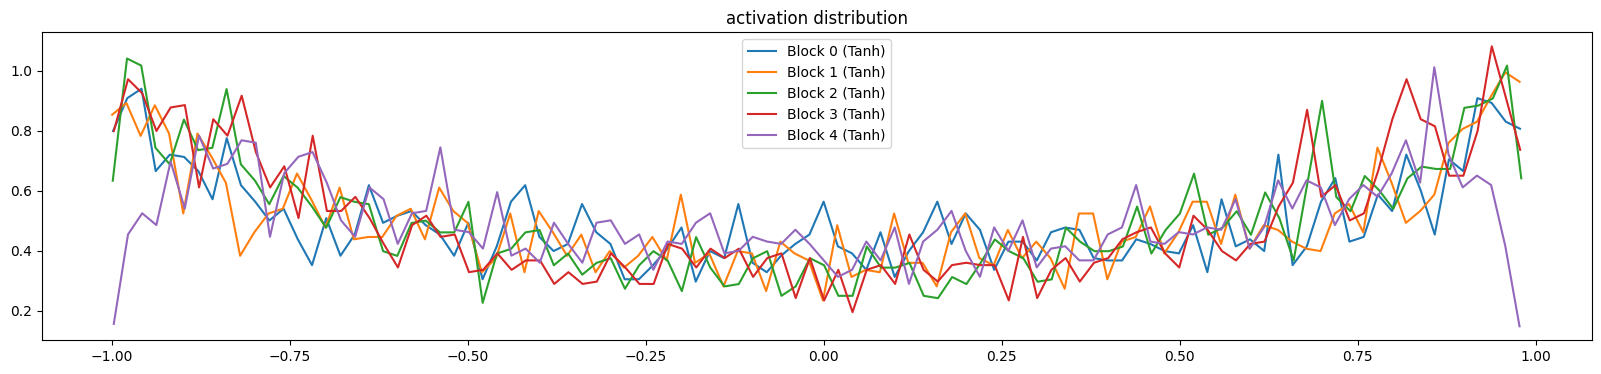

In [172]:
# training code
plt.figure(figsize=(20,4))
legends = []
tanh_layers = []
for mlayer in model.layers:
    if isinstance(mlayer, Block):
        for blayer in mlayer.layers:
            if isinstance(blayer, Tanh):
                tanh_layers.append(blayer)

for i, layer in enumerate(tanh_layers):
    t = layer.out
    print(f"Block {i}\t({layer.__class__.__name__}) |\tmean: {t.mean():+4f}\t\tstd: {t.std():+4f}\t\tsaturation: {(t.abs() > 0.97).float().mean()*100:3f}%")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"Block {i} ({layer.__class__.__name__})")

plt.title("activation distribution")
plt.legend(legends)
plt.plot();

Block 0	(Tanh) |	mean: -0.000000		std: +0.002428
Block 1	(Tanh) |	mean: -0.000000		std: +0.002336
Block 2	(Tanh) |	mean: +0.000000		std: +0.002382
Block 3	(Tanh) |	mean: +0.000000		std: +0.002352
Block 4	(Tanh) |	mean: +0.000007		std: +0.002837


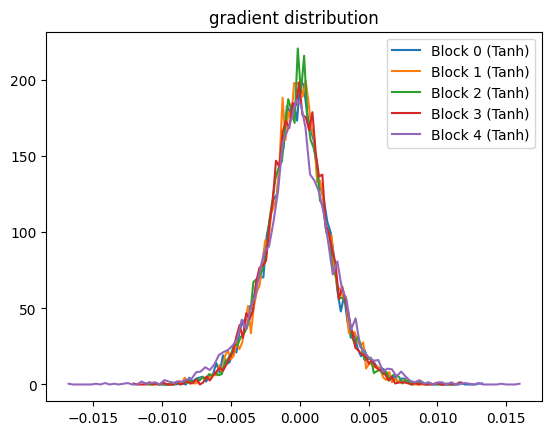

In [178]:
for i, layer in enumerate(tanh_layers):
    t = layer.out.grad
    print(f"Block {i}\t({layer.__class__.__name__}) |\tmean: {t.mean():+4f}\t\tstd: {t.std():+4f}")
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())

plt.title("gradient distribution")
plt.legend(legends)
plt.plot();

weight	(27, 10)	| mean +0.000000 | std +0.011442 | grad:data +0.011341
weight	(30, 200)	| mean -0.000022 | std +0.005665 | grad:data +0.018280
weight	(200, 200)	| mean -0.000002 | std +0.003926 | grad:data +0.031202
weight	(200, 200)	| mean -0.000013 | std +0.003973 | grad:data +0.032014
weight	(200, 200)	| mean -0.000008 | std +0.004090 | grad:data +0.032715
weight	(200, 200)	| mean -0.000013 | std +0.003963 | grad:data +0.031771
weight	(200, 27)	| mean +0.000000 | std +0.018575 | grad:data +0.189441


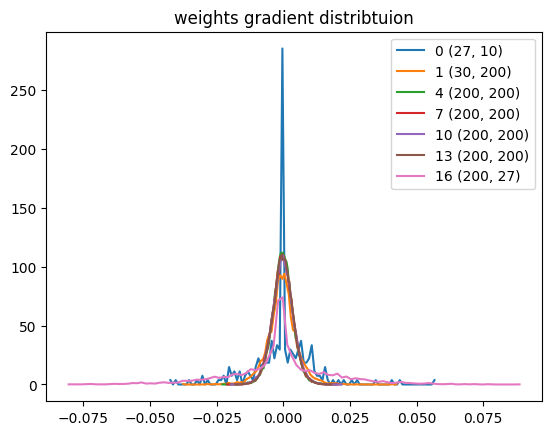

In [183]:
legends = []
for i, p in enumerate(model.parameters()):
    if p.ndim == 2:
        t = p.grad
        print(f"weight\t{tuple(p.shape)}\t| mean {t.mean():+4f} | std {t.std():+4f} | grad:data {(t.std() / p.std()):+4f}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.title("weights gradient distribtuion")
plt.legend(legends)
plt.plot();